<a href="https://colab.research.google.com/github/eaishwa/breast-cancer-identification/blob/master/Breast_Cancer_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Detection using Convolutional Neural Networks

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

In this project, I have explored and leveraged convolutional neural networks to accurately classify if the image contains cancerous cells or not.

The dataset is taken from kaggle

https://www.kaggle.com/paultimothymooney/breast-histopathology-images

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
import os

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 62 Sep 11 23:51 kaggle.json
{"username":"av2845","key":"a597455fba9139049bee5dfe1c6becc8"}

In [5]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.0MB/s 
     |████████████████████████████████| 5.3MB 7.8MB/s 
     |████████████████████████████████| 102kB 31.0MB/s 
     |████████████████████████████████| 51kB 22.3MB/s 
     |████████████████████████████████| 112kB 56.0MB/s 


In [6]:
!kaggle datasets download paultimothymooney/breast-histopathology-images

100% 1.48G/1.49G [00:30<00:00, 59.9MB/s]
100% 1.49G/1.49G [00:31<00:00, 51.5MB/s]


In [10]:
!unzip /content/breast-histopathology-images.zip

Archive:  /content/breast-histopathology-images.zip
  inflating: IDC_regular_ps50_idx5.zip  


In [0]:
import zipfile

zip_file = zipfile.ZipFile('IDC_regular_ps50_idx5.zip', 'r')
zip_file.extractall('/content')
zip_file.close()

In [0]:
!rm IDC_regular_ps50_idx5.zip

# Read the images into class 0 and 1

In [0]:
import cv2
import os

files = os.listdir('/content')
new_files = [f for f in files if f != '.config' and f != 'adc.json' and f != 'kaggle.json' and f != 'sample_data']
class0 = []
class1 = []

# choose 20 files from which images are read, done to reduce overhead
for i in range(0,20):
  f1 = new_files[i]
  for classes in os.listdir('/content/'+ f1):
     for img in os.listdir('/content/'+ f1+ '/' + classes):
        if classes == '0':
          class0.append(cv2.imread('/content/' + f1+ '/' + classes + '/' + img))
        else:
          class1.append(cv2.imread('/content/' + f1+ '/' + classes + '/' + img))

In [0]:
print(class0[0].shape)
print(class1[0].shape)

(50, 50, 3)
(50, 50, 3)


# Exclude images that are corrupt

In [0]:
import numpy as np

class0_clean = []
class1_clean = []

for img in class0:
  
  # if shape is wrong, exclude them
  if img is None or img.shape[0] != 50 or img.shape[1] != 50:
    continue
  class0_clean.append(img)
  
for img in class1:
  if img is None or img.shape[0] != 50 or img.shape[1] != 50:
    continue
  class1_clean.append(img)

class0_data = np.array(class0_clean)
class1_data = np.array(class1_clean)

print(class0_data.shape)
print(class1_data.shape)


train_array = np.append(class0_data, class1_data,axis=0)

(18631, 50, 50, 3)
(4889, 50, 50, 3)


# Import necessary libraries

In [0]:
import pandas as pd
from keras.datasets import mnist
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import numpy as np
from keras.layers.normalization import BatchNormalization

In [0]:
train_array.shape

(23520, 50, 50, 3)

In [0]:
y_1 = np.ones(4889)
y_0 = np.zeros(18631)
y = np.append(y_0,y_1,axis=0)

# Train test split the data

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_array, y, test_size=0.2, random_state=42)

# CNN with dropout and batch normalization**

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def run_cnn(layers,dropout,units,X_input, y_input, epochs):
  model = Sequential()
  model.add(Conv2D(256, (3,3), activation='relu', input_shape=(X_train.shape[1:])))
  model.add(Flatten())

  for i in range(0,layers):
    model.add(Dense(units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  history_callback = model.fit(X_input, y_input, batch_size=50, epochs=epochs, verbose=1, validation_split=0.2)
  return pd.DataFrame(history_callback.history), model

Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 18s 1ms/step - loss: 0.5199 - acc: 0.7599 - val_loss: 0.4978 - val_acc: 0.8037
Epoch 2/10
15052/15052 [==============================] - 16s 1ms/step - loss: 0.4140 - acc: 0.8110 - val_loss: 0.5874 - val_acc: 0.7883
Epoch 3/10
15052/15052 [==============================] - 16s 1ms/step - loss: 0.3923 - acc: 0.8174 - val_loss: 0.5231 - val_acc: 0.7851
Epoch 4/10
15052/15052 [==============================] - 16s 1ms/step - loss: 0.3703 - acc: 0.8264 - val_loss: 0.5353 - val_acc: 0.8196
Epoch 5/10
15052/15052 [==============================] - 16s 1ms/step - loss: 0.3729 - acc: 0.8232 - val_loss: 0.4070 - val_acc: 0.8047
Epoch 6/10
15052/15052 [==============================] - 15s 1ms/step - loss: 0.3579 - acc: 0.8350 - val_loss: 0.9808 - val_acc: 0.2811
Epoch 7/10
15052/15052 [==============================] - 16s 1ms/step - loss: 0.3502 - acc: 0.8354 - val_loss: 1.5741 - val_acc:

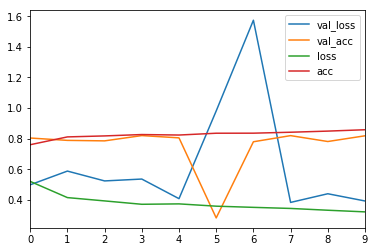

In [0]:
results, model = run_cnn(3,0.3,64, X_train, y_train, 10)
print(results)
results.plot()

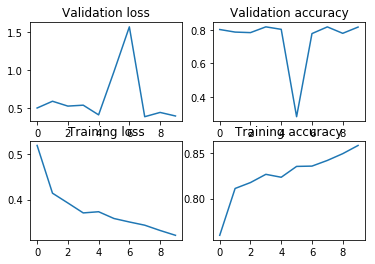

In [0]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2)
_ = axes[0,0].plot(pd.Series(results.index),results['val_loss'])
_ = axes[0,0].set_title('Validation loss')
_ = axes[0,1].plot(pd.Series(results.index),results['val_acc'])
_ = axes[0,1].set_title('Validation accuracy')
_ = axes[1,0].plot(pd.Series(results.index),results['loss'])
_ = axes[1,0].set_title('Training loss')
_ = axes[1,1].plot(pd.Series(results.index),results['acc'])
_ = axes[1,1].set_title('Training accuracy')

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.400
Test Accuracy: 0.809


A basic CNN network with batch normalization and dropouts is giving a decent accuracy of 80.9%

# Experimenting with rotation, vertical flip mirroring and image translation

Let us rotate the images and see how the model is performing

In [0]:
X_train[0].shape

(50, 50, 3)

In [0]:
import cv2

rows,cols = X_train[0].shape[0], X_train[0].shape[1]

M = cv2.getRotationMatrix2D((50/2,50/2),90,1)
imgs_rotated = []

for img in X_train:
  imgs_rotated.append(cv2.warpAffine(img,M,(50,50)))
  
X_train_rotated = np.array(imgs_rotated)

Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 18s 1ms/step - loss: 0.5163 - acc: 0.7588 - val_loss: 0.5535 - val_acc: 0.7909
Epoch 2/10
15052/15052 [==============================] - 15s 983us/step - loss: 0.4045 - acc: 0.8137 - val_loss: 0.4369 - val_acc: 0.7872
Epoch 3/10
15052/15052 [==============================] - 15s 984us/step - loss: 0.3885 - acc: 0.8206 - val_loss: 1.1308 - val_acc: 0.2285
Epoch 4/10
15052/15052 [==============================] - 15s 982us/step - loss: 0.3767 - acc: 0.8218 - val_loss: 0.8850 - val_acc: 0.7795
Epoch 5/10
15052/15052 [==============================] - 15s 988us/step - loss: 0.3648 - acc: 0.8289 - val_loss: 0.4012 - val_acc: 0.8154
Epoch 6/10
15052/15052 [==============================] - 15s 998us/step - loss: 0.3498 - acc: 0.8377 - val_loss: 0.6666 - val_acc: 0.7811
Epoch 7/10
15052/15052 [==============================] - 15s 986us/step - loss: 0.3377 - acc: 0.8439 - val_loss: 0.514

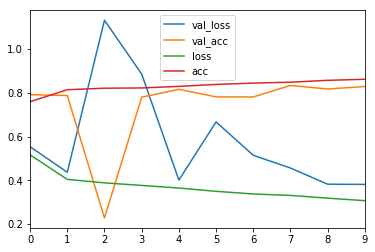

In [0]:
# using baseline
results, model_rotated = run_cnn(3,0.3,64, X_train_rotated, y_train,10)
print(results)
results.plot()

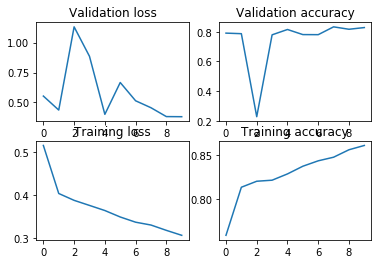

In [0]:
fig, axes = plt.subplots(2, 2)
_ = axes[0,0].plot(pd.Series(results.index),results['val_loss'])
_ = axes[0,0].set_title('Validation loss')
_ = axes[0,1].plot(pd.Series(results.index),results['val_acc'])
_ = axes[0,1].set_title('Validation accuracy')
_ = axes[1,0].plot(pd.Series(results.index),results['loss'])
_ = axes[1,0].set_title('Training loss')
_ = axes[1,1].plot(pd.Series(results.index),results['acc'])
_ = axes[1,1].set_title('Training accuracy')

In [0]:
score = model_rotated.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.376
Test Accuracy: 0.820


On rotating, the accuracy score has improved from the previous value.

**Verical Flip Mirroring**

In [0]:
imgs_mirrored = []

for img in X_train:
  imgs_mirrored.append(cv2.flip(img,1))
  
X_train_mirrored = np.array(imgs_mirrored)
print(X_train_mirrored.shape)
  

(18816, 50, 50, 3)


Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 19s 1ms/step - loss: 0.5089 - acc: 0.7673 - val_loss: 0.6209 - val_acc: 0.7112
Epoch 2/10
15052/15052 [==============================] - 15s 1ms/step - loss: 0.3984 - acc: 0.8199 - val_loss: 0.4485 - val_acc: 0.7933
Epoch 3/10
15052/15052 [==============================] - 15s 1ms/step - loss: 0.3854 - acc: 0.8254 - val_loss: 0.5130 - val_acc: 0.7891
Epoch 4/10
15052/15052 [==============================] - 15s 1ms/step - loss: 0.3770 - acc: 0.8271 - val_loss: 0.4203 - val_acc: 0.8114
Epoch 5/10
15052/15052 [==============================] - 15s 995us/step - loss: 0.3616 - acc: 0.8356 - val_loss: 0.4803 - val_acc: 0.8124
Epoch 6/10
15052/15052 [==============================] - 15s 983us/step - loss: 0.3514 - acc: 0.8384 - val_loss: 2.1101 - val_acc: 0.7798
Epoch 7/10
15052/15052 [==============================] - 15s 1ms/step - loss: 0.3380 - acc: 0.8509 - val_loss: 0.4045 - val_

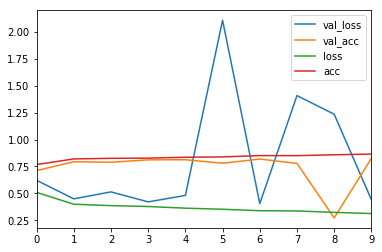

In [0]:
# using original baseline
results, model_flip = run_cnn(3,0.2,64, X_train_mirrored, y_train,10)
print(results)
results.plot()

In [0]:
score = model_flip.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.450
Test Accuracy: 0.812


**Image Translation**

In [0]:
imgs_translated = []

for img in X_train:
  imgs_translated.append(cv2.flip(img,1))
  
X_train_translated = np.array(imgs_translated)
print(X_train_translated.shape)
  

(18816, 50, 50, 3)


Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 20s 1ms/step - loss: 0.4979 - acc: 0.7667 - val_loss: 0.7151 - val_acc: 0.7811
Epoch 2/10
15052/15052 [==============================] - 15s 979us/step - loss: 0.4032 - acc: 0.8194 - val_loss: 1.2293 - val_acc: 0.7792
Epoch 3/10
15052/15052 [==============================] - 15s 983us/step - loss: 0.3885 - acc: 0.8190 - val_loss: 0.5127 - val_acc: 0.7747
Epoch 4/10
15052/15052 [==============================] - 15s 980us/step - loss: 0.3750 - acc: 0.8241 - val_loss: 0.6996 - val_acc: 0.7803
Epoch 5/10
15052/15052 [==============================] - 15s 977us/step - loss: 0.3698 - acc: 0.8279 - val_loss: 0.8229 - val_acc: 0.7795
Epoch 6/10
15052/15052 [==============================] - 15s 987us/step - loss: 0.3533 - acc: 0.8367 - val_loss: 0.4472 - val_acc: 0.8124
Epoch 7/10
15052/15052 [==============================] - 15s 988us/step - loss: 0.3426 - acc: 0.8431 - val_loss: 0.415

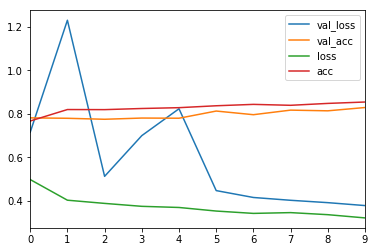

In [0]:
# baseline
results, model_translated = run_cnn(3,0.2,64, X_train_translated, y_train,10)
print(results)
results.plot()

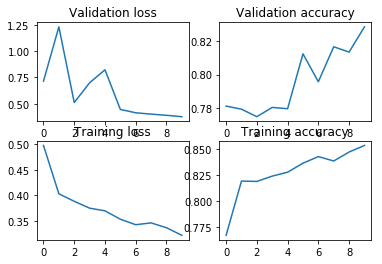

In [0]:
fig, axes = plt.subplots(2, 2)
_ = axes[0,0].plot(pd.Series(results.index),results['val_loss'])
_ = axes[0,0].set_title('Validation loss')
_ = axes[0,1].plot(pd.Series(results.index),results['val_acc'])
_ = axes[0,1].set_title('Validation accuracy')
_ = axes[1,0].plot(pd.Series(results.index),results['loss'])
_ = axes[1,0].set_title('Training loss')
_ = axes[1,1].plot(pd.Series(results.index),results['acc'])
_ = axes[1,1].set_title('Training accuracy')

In [0]:
score = model_translated.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.387
Test Accuracy: 0.822


# Deep model with Residual Connections

Let us experiment with residual connections. As the model goes deep, it won't be able to learn without residual connections. This is experimented in the below section

In [0]:
from keras.layers import Input, Dense
from keras.models import Model


def run_cnn_deep(layers,dropout,units,X_input, y_input, epochs):

  inputs = Input(shape=(50,50,3))
  x = Conv2D(256, (3,3), activation='relu', input_shape=(X_train.shape[1:]))(inputs)
  # x = Conv2D(256, (3,3), activation='relu', input_shape=(X_train.shape[1:]))
  x = Flatten()(x)
  x = Dense(units, activation='relu')(x)
  print('About to add layers iteratively')
  
  for i in range(0,layers-1):
  x = Conv2D(256, (3,3), activation='relu', input_shape=(X_train.shape[1:]))(x)
    x = Flatten()(x)
    x = Dense(units, activation='relu')(x)
    # x = Dropout(dropout)(x)
    
  
  predictions = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=predictions)
  print(model.summary())
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  history_callback = model.fit(X_input, y_input, batch_size=50, epochs=epochs, verbose=1, validation_split=0.2)
  return pd.DataFrame(history_callback.history), model

In [0]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten,add,Dense
from keras.models import Model
num_classes = 10
inputs = Input(shape=(50, 50, 3))

conv1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)
conv2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)
conv4 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv3)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)
conv6 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv5)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
conv7 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool3)
conv8 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv7)


skip2 = add([maxpool3, conv8])
maxpool4 = MaxPooling2D(pool_size=(2, 2))(skip2)
flat = Flatten()(maxpool4)
dense = Dense(10, activation='relu')(flat)
predictions = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
history_callback = model.fit(X_train, y_train, batch_size=50, epochs=10, verbose=1, validation_split=0.2)


Instructions for updating:
Use tf.cast instead.
Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 10s 679us/step - loss: 0.5305 - acc: 0.7905 - val_loss: 0.5152 - val_acc: 0.7800
Epoch 2/10
15052/15052 [==============================] - 4s 253us/step - loss: 0.4727 - acc: 0.7964 - val_loss: 0.4670 - val_acc: 0.7800
Epoch 3/10
15052/15052 [==============================] - 4s 255us/step - loss: 0.4257 - acc: 0.8129 - val_loss: 0.4399 - val_acc: 0.8018
Epoch 4/10
15052/15052 [==============================] - 4s 254us/step - loss: 0.3888 - acc: 0.8310 - val_loss: 0.3851 - val_acc: 0.8318
Epoch 5/10
15052/15052 [==============================] - 4s 254us/step - loss: 0.3746 - acc: 0.8390 - val_loss: 0.3885 - val_acc: 0.8332
Epoch 6/10
15052/15052 [==============================] - 4s 255us/step - loss: 0.3696 - acc: 0.8378 - val_loss: 0.3696 - val_acc: 0.8491
Epoch 7/10
15052/15052 [==============================] - 4s 254us/step - 

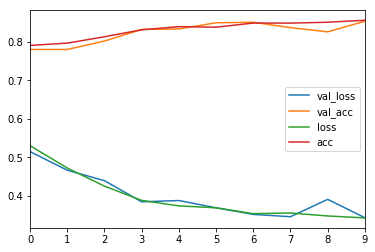

In [0]:
pd.DataFrame(data=history_callback.history).plot()

With residual connections and 8 convolutional layers, the model is able to learn.

# Deep network without residual connections

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten

def run_cnn_deep_nores(layers,dropout,units,X_input, y_input, epochs):
  model = Sequential()
  model.add(Conv2D(256, (3,3), activation='relu', input_shape=(X_train.shape[1:])))
  model.add(Flatten())

  for i in range(0,layers):
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  history_callback = model.fit(X_input, y_input, batch_size=50, epochs=epochs, verbose=1, validation_split=0.2)
  return pd.DataFrame(history_callback.history), model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 15052 samples, validate on 3764 samples
Epoch 1/10
15052/15052 [==============================] - 18s 1ms/step - loss: 3.4785 - acc: 0.7828 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 2/10
15052/15052 [==============================] - 15s 1ms/step - loss: 3.2799 - acc: 0.7965 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 3/10
15052/15052 [==============================] - 16s 1ms/step - loss: 3.2810 - acc: 0.7964 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 4/10
15052/15052 [==============================] - 15s 1ms/step - loss: 3.2821 - acc: 0.7964 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 5/10
15052/15052 [==============================] - 16s 1ms/step - loss: 3.2831 - acc: 0.7963 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 6/10
15052/15052 [==============================] - 15s 1ms/step - loss: 3.2821 - acc: 0.7964 - val_loss: 3.5456 - val_acc: 0.7800
Epoch 7/10
150

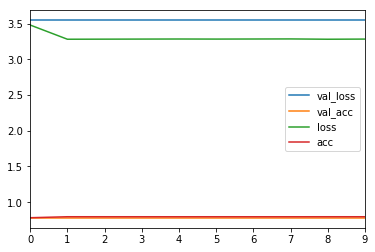

In [0]:
results, model_cnn_deep_nores = run_cnn_deep_nores(15,0.2,64, X_train, y_train,10)
print(results)
results.plot()

The model fails to learn anything without having residual connections.